# Пример тестового задания из компании OZON
Выполнил : Вячеслав Сафронский (v-safronskij-22)

##### Задание 1. В данном задании необходимо написать несколько SQL-запросов для определенных таблиц.
Таблицы НЕ предоставленны  в явном виде.

Задача 1. Посчитать % изменение количества клиентов, совершивших покупку, месяц-к-месяцу 

Задача 2. Вывести сумму GMV (Gross Merchandise Value) с нарастающим итогом по дням .

Задача 3. Получить время отклика на каждое письмо (письмо идентифицируется по полю mail_id),
отправленное пользователем mr_employee@ozon.ru.

Задача 4. Вывести id сотрудников с разницей в заработной плате в пределах 5000 рублей.

##### Задание 2 - Case Study. Опыт продавца.

Задача 1. Нарисовать процесс регистрации и выхода продавца на Маркетплейс от момента регистрации до 1-ой продажи по схеме DBS и описать основные отличия от схемы FBO и FBS

In [1]:
from IPython.display import Image

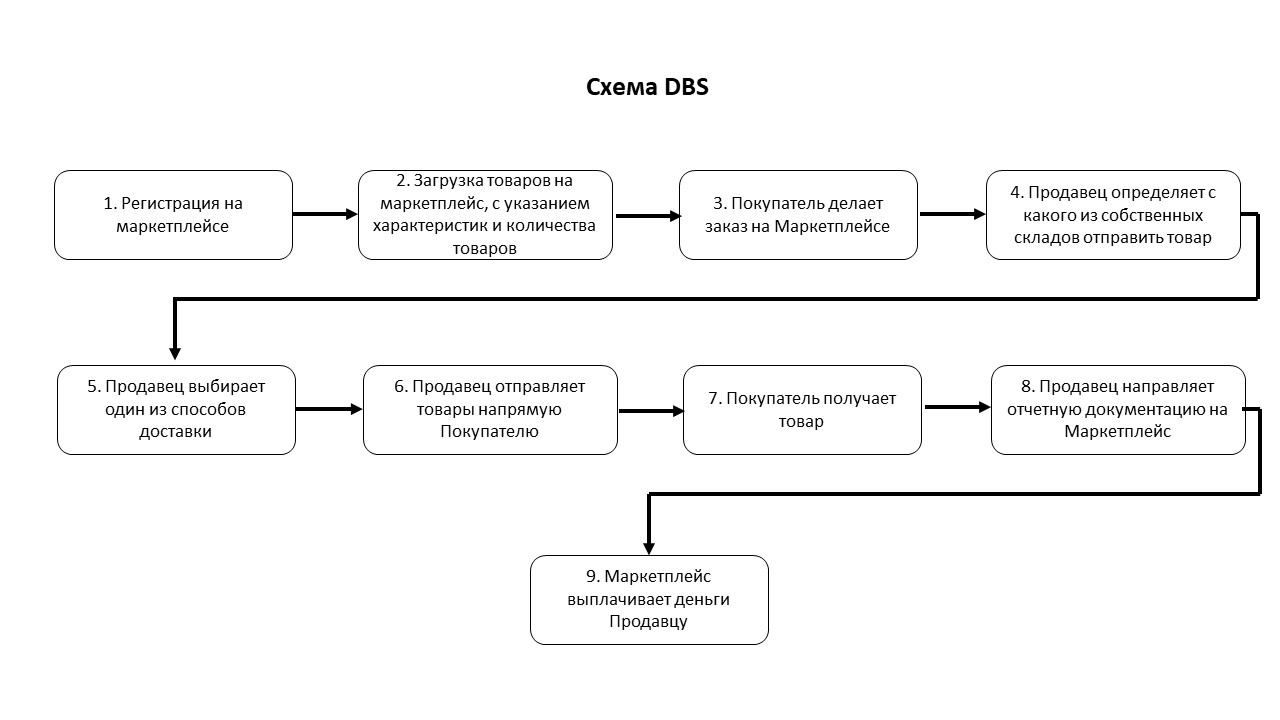

In [2]:
Image("C:/Users/user/study/final_project/slide1_ex_1.JPG")

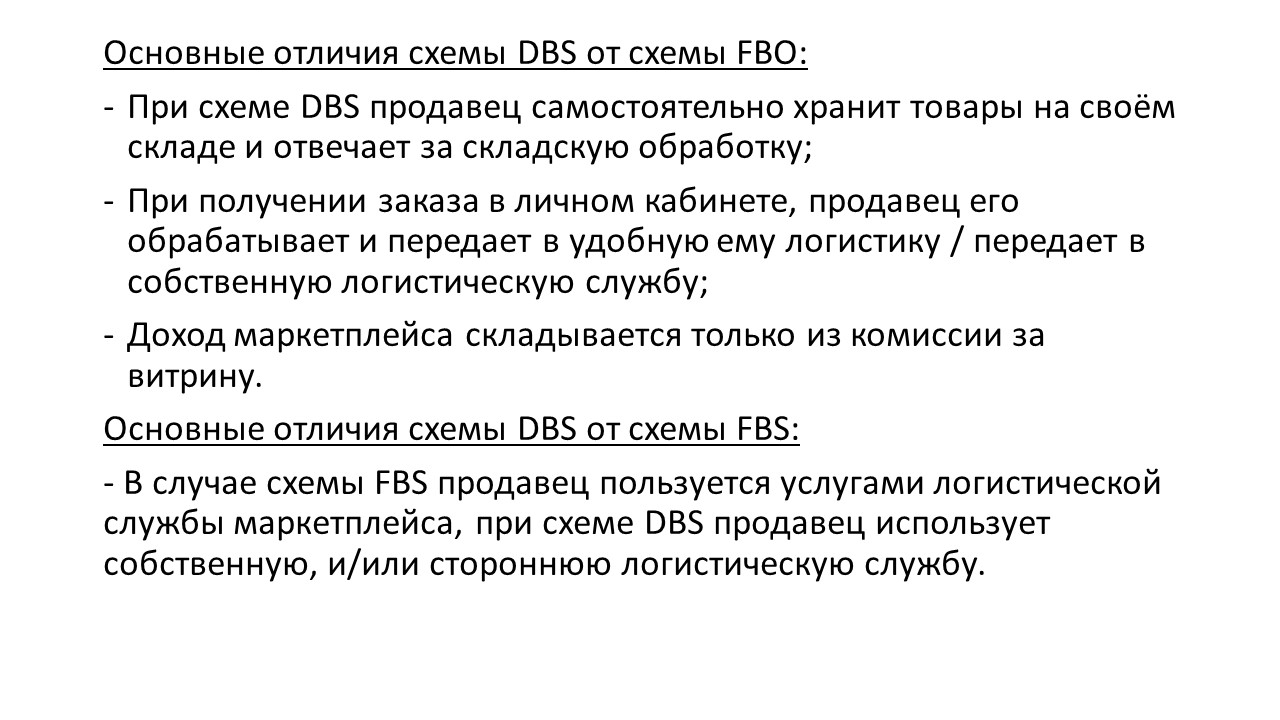

In [3]:
Image("C:/Users/user/study/final_project/slide_2_ex_1.JPG")

Задача 2. Описать основные сложности, которые могут возникнуть на каждом этапе с момента регистрации и первой продажи по схеме DBS

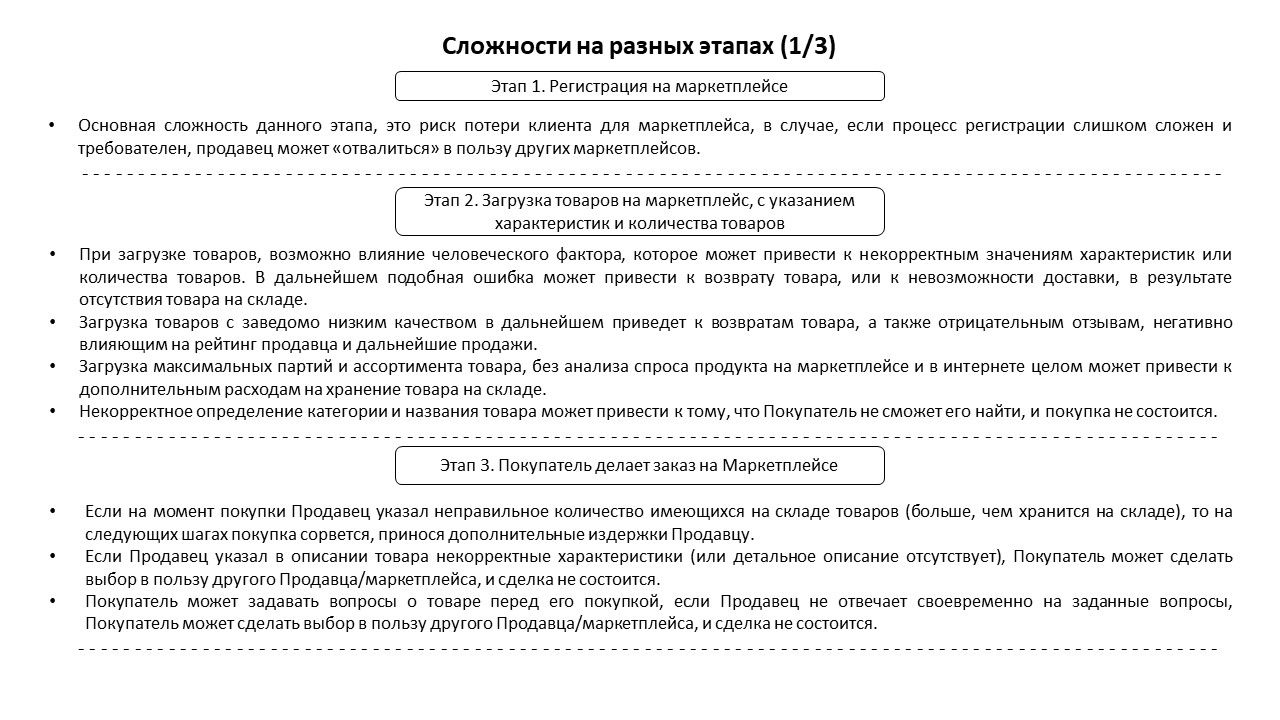

In [4]:
Image("C:/Users/user/study/final_project/slide_1_ex_2.JPG")

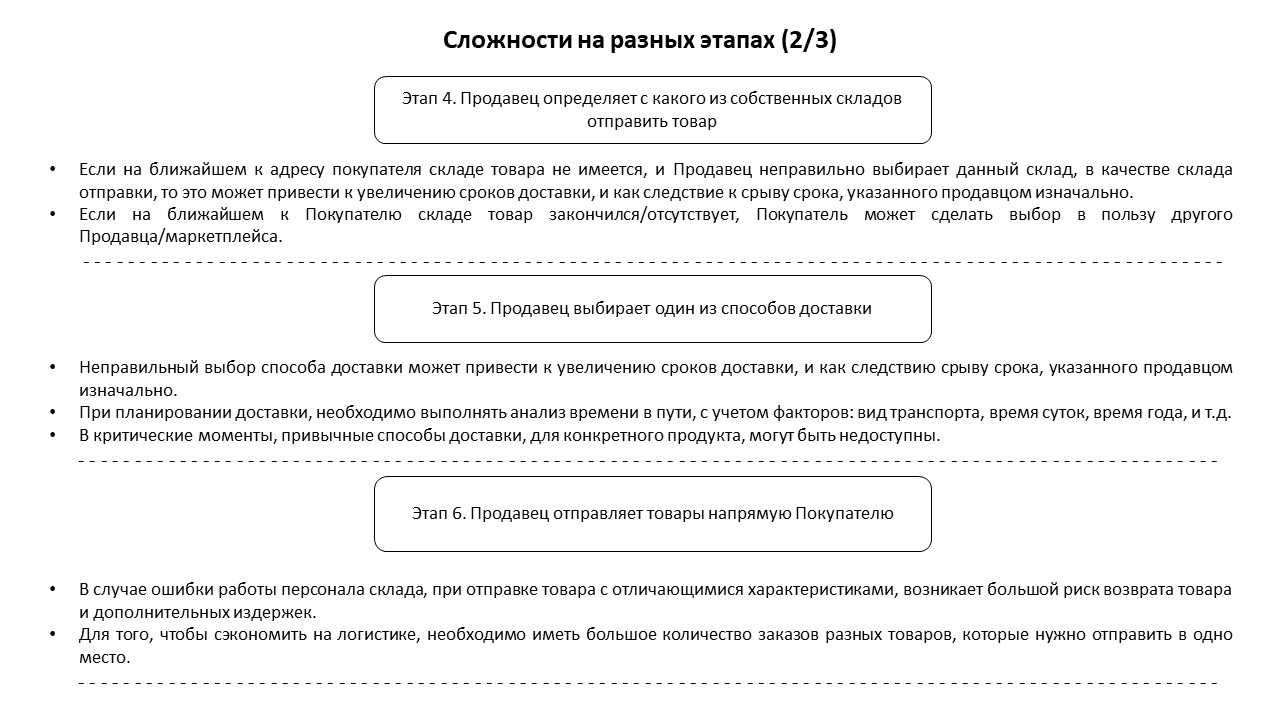

In [5]:
Image("C:/Users/user/study/final_project/slide_2_ex_2.JPG")

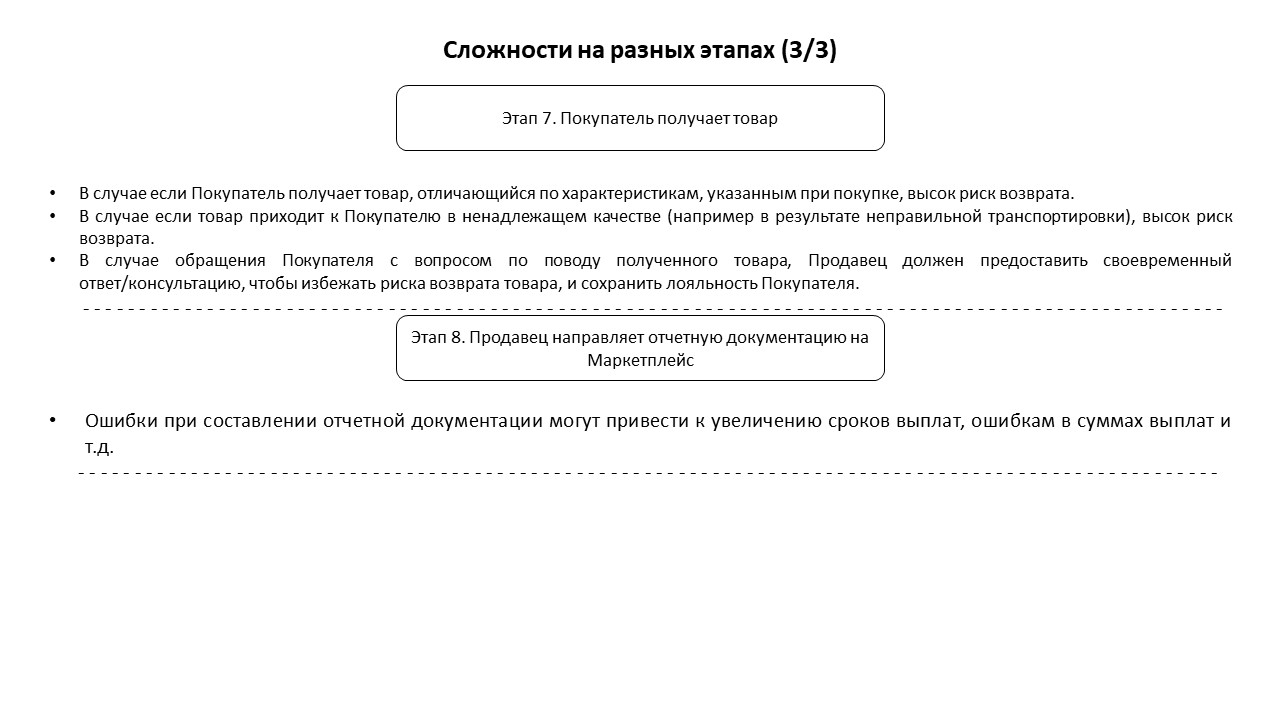

In [6]:
Image("C:/Users/user/study/final_project/slide_3_ex_2.JPG")

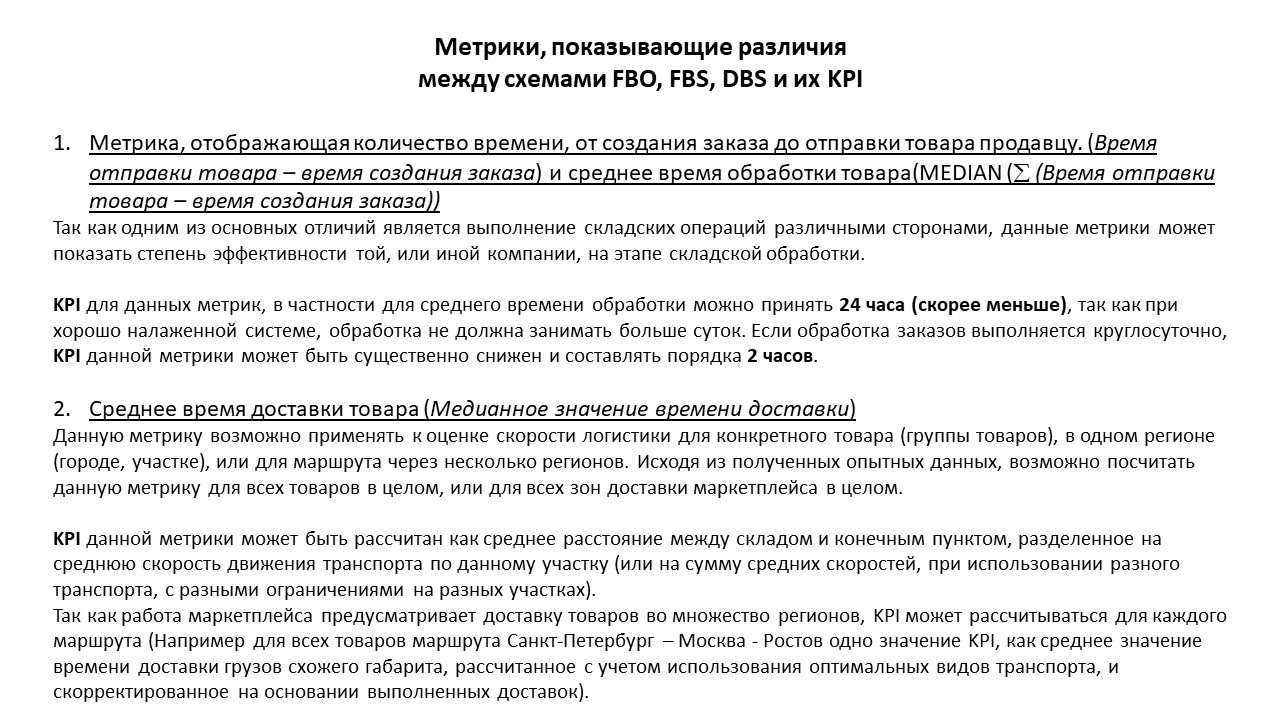

In [7]:
Image("C:/Users/user/study/final_project/slide_01_ex_3_4.JPG")

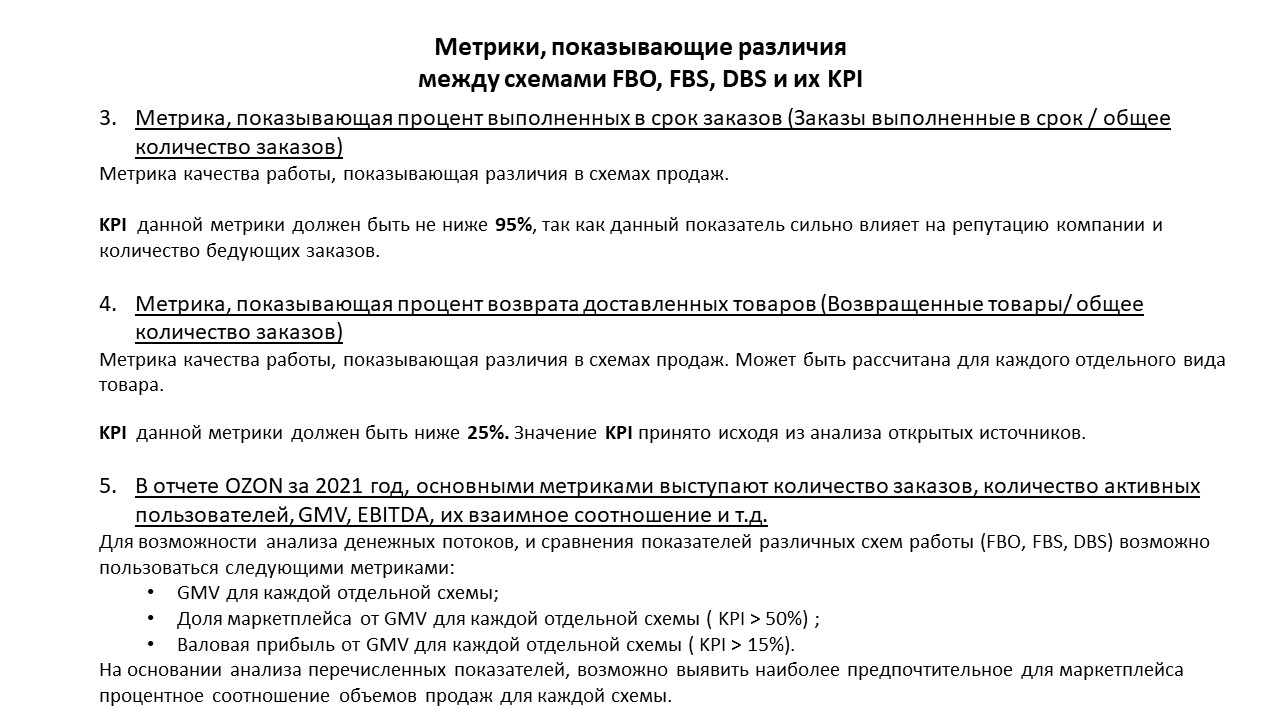

In [8]:
Image("C:/Users/user/study/final_project/slide_02_ex_3_4.JPG")

##### Задание 3. Метрики — показатели, с помощью которых измеряют эффективность процессов на каждом этапе.

Ниже приведено решение при помощи pandas.
Также метрики рассчитаны в Tableau - дашборд по следующей ссылке: https://public.tableau.com/app/profile/viacheslav.safronskii/viz/v-safronskijvariant4assignment4-metrics/Dashboard1?publish=yes

In [9]:
# импортируем требуемые библиотеки

In [10]:
import pandahouse as ph
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
#устанавливаем соединение с clickhouse
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

In [12]:
#создаем SQL - запрос, и загружаем таблицу product_online

In [13]:
query = """
SELECT *
FROM {db}.product_online
"""
df_product = ph.read_clickhouse(query, connection=connection)

In [14]:
#создаем SQL - запрос, и загружаем таблицу returns_online

In [15]:
query_1 = """
SELECT *
FROM {db}.returns_online
"""
df_returns = ph.read_clickhouse(query_1, connection=connection)

In [16]:
# таблица logistics_online не загружается подобным способом из-за ощибки KeyError: Nullable(Date) 
# или (KeyError: Nullable(String)), так как pandahouse не работает с nullable.
# Таблицу выгрудаем через Tabix в файл .csv и загружаем командой pd.read_csv

In [17]:
df_logistics = pd.read_csv('C:/Users/user/study/final_project/logistics_online_2-Copy1.csv', parse_dates = ['date_order', 'planned_data_order', 'result_data_order'])

In [18]:
df_logistics.head(5)

,date_order,number_order,planned_data_order,timeslot_number,result_data_order,delivery_type,carrier_name,seller_ID,order_status,customer_cluster,warehouse_cluster
0,2021-5-01,313655114,2021-14-01,1,2021-11-01,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва
1,2021-3-01,315229153,2021-11-01,1,2021-8-01,Курьер,Самодоставка,40560,Доставлен,Кластер Московская область,Кластер Московская область
2,2021-8-01,3114106095,2021-16-01,1,2021-14-01,Курьер,Самодоставка,40560,Доставлен,Кластер Московская область,Кластер Московская область
3,2021-12-01,31145541407,2021-20-01,1,2021-15-01,Самовывоз,3PL 1,301202,Доставлен,Кластер Санкт-Петербург,Кластер Москва
4,2021-16-01,325050136,2021-26-01,1,2021-25-01,Самовывоз,3PL 1,946233,Доставлен,Кластер Санкт-Петербург,Кластер Санкт-Петербург


In [19]:
# проверяем данные, видим, что имеются NaN значения.
# Для расчета временных метрик далее необходимо будет удалить строки без даты в столбце date_order.

In [20]:
df_logistics.isna().sum()

date_order            625
number_order            0
planned_data_order      0
timeslot_number         0
result_data_order     890
delivery_type           0
carrier_name            0
seller_ID               0
order_status            0
customer_cluster        0
warehouse_cluster       0
dtype: int64

In [21]:
# проверяем типы данных. Видим, что столбцы с датами имеют тип object. Необходимо привести к корректному формату и типу.

In [22]:
df_logistics.dtypes

date_order            object
number_order           int64
planned_data_order    object
timeslot_number        int64
result_data_order     object
delivery_type         object
carrier_name          object
seller_ID              int64
order_status          object
customer_cluster      object
warehouse_cluster     object
dtype: object

In [23]:
# создаем и используем несколько функций для корректировки формата даты из YYYY-D-MM в YYYY-MM-DD

In [24]:
 def fix_dates(x):
        if str(x).startswith('202') :
            return x.split('-')[0] + '-' + x.split('-')[2] + '-' + x.split('-')[1]
        else:
            return x

In [25]:
 def fix_dates_2(x):
        if str(x).startswith('202') and str(x).split('-')[1] == '012':
            return x.split('-')[0] + '-' + '12' + '-' + x.split('-')[2]
        else:
            return x

In [26]:
 def fix_dates_3(x):
        if str(x).startswith('202') and str(x).split('-')[1] == '002':
            return x.split('-')[0] + '-' + '02' + '-' + x.split('-')[2]
        else:
            return x

In [27]:
df_logistics.date_order = df_logistics.date_order.apply(fix_dates)

In [28]:
df_logistics.date_order = df_logistics.date_order.apply(fix_dates_2)

In [29]:
df_logistics.date_order = df_logistics.date_order.apply(fix_dates_3)

In [30]:
df_logistics.date_order = pd.to_datetime(df_logistics.date_order)

In [31]:
df_logistics.planned_data_order = df_logistics.planned_data_order.apply(fix_dates)

In [32]:
df_logistics.planned_data_order = pd.to_datetime(df_logistics.planned_data_order)

In [33]:
df_logistics.result_data_order = df_logistics.result_data_order.apply(fix_dates)

In [34]:
df_logistics.result_data_order = df_logistics.result_data_order.apply(fix_dates_2)

In [35]:
df_logistics.result_data_order = pd.to_datetime(df_logistics.result_data_order)

In [36]:
df_logistics.head(5)

,date_order,number_order,planned_data_order,timeslot_number,result_data_order,delivery_type,carrier_name,seller_ID,order_status,customer_cluster,warehouse_cluster
0,2021-01-05,313655114,2021-01-14,1,2021-01-11,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва
1,2021-01-03,315229153,2021-01-11,1,2021-01-08,Курьер,Самодоставка,40560,Доставлен,Кластер Московская область,Кластер Московская область
2,2021-01-08,3114106095,2021-01-16,1,2021-01-14,Курьер,Самодоставка,40560,Доставлен,Кластер Московская область,Кластер Московская область
3,2021-01-12,31145541407,2021-01-20,1,2021-01-15,Самовывоз,3PL 1,301202,Доставлен,Кластер Санкт-Петербург,Кластер Москва
4,2021-01-16,325050136,2021-01-26,1,2021-01-25,Самовывоз,3PL 1,946233,Доставлен,Кластер Санкт-Петербург,Кластер Санкт-Петербург


In [37]:
#проверяем результат и типы, видим, что данные в столбцах с датой приняли нужный нам вид и тип.

In [38]:
df_logistics.dtypes

date_order            datetime64[ns]
number_order                   int64
planned_data_order    datetime64[ns]
timeslot_number                int64
result_data_order     datetime64[ns]
delivery_type                 object
carrier_name                  object
seller_ID                      int64
order_status                  object
customer_cluster              object
warehouse_cluster             object
dtype: object

In [39]:
df_returns.dtypes

number_order              int64
product_ID                int64
amount_return              int8
return_date      datetime64[ns]
dtype: object

In [40]:
df_product.dtypes

number_order       int64
product_ID         int64
product_price    float64
amount             int16
dtype: object

In [41]:
#данные отформатированы. Переходим к задачам.

#### Задача 1.Посчитать OnTime - Метрика своевременности доставки. (Доставили в плановую дату доставки или нет), в %
- Необходимо видеть изменение метрики по дням
- Необходимы разрезы по перевозчикам, по типу доставки, по кластерам склада, по таймслотам

In [42]:
df_logistics = df_logistics.sort_values('date_order')

In [43]:
#для расчета метрики определяем количество дней между фактической и плановой доставками.

In [44]:
df_logistics['day_difference'] = (df_logistics.result_data_order - df_logistics.planned_data_order).dt.days

In [45]:
# создаем функцию для задания маркера, определяющего была ли доставлена посылка вовремя.

In [46]:
def define_on_time (x):
    if x < 0:
        return 1
    else:
        return 0

In [47]:
df_logistics['on_time_marker'] = df_logistics['day_difference'].apply(define_on_time)

In [48]:
# рассчитываем общее значение метрики OnTime.

In [49]:
Overall_on_time = ((df_logistics.on_time_marker.sum() / df_logistics.shape[0])*100).round(2)
print(f'Значение метрики OnTime, рассчитанное по всем заказам равно {Overall_on_time} процентов')

Значение метрики OnTime, рассчитанное по всем заказам равно 60.44 процентов


In [50]:
#Так как для строк в которых пропущены значения даты заказа посчитать  временные метрики из следующих заказов нельзя,
#данные строки удаляем из датафрейма и выполняем расчет OnTime заного

In [51]:
df_logistics = df_logistics.query("date_order > '2020-01-01'")

In [52]:
Overall_on_time = ((df_logistics.on_time_marker.sum() / df_logistics.shape[0])*100).round(2)
print(f'Значение метрики OnTime, рассчитанное по заказам без пропущенной даты равно {Overall_on_time} процентов')

Значение метрики OnTime, рассчитанное по заказам без пропущенной даты равно 62.42 процентов


In [54]:
# рассчитываем сколько заказов было доставлено вовремя по дням

In [55]:
on_time_orders_daily = df_logistics.groupby('date_order', as_index = False).agg({'on_time_marker' : 'sum'}).rename(columns={'on_time_marker' : 'on_time_orders'})

In [56]:
# рассчитываем сколько всего заказов было доставлено  по дням

In [57]:
all_orders_daily = df_logistics.groupby('date_order', as_index = False).agg({'on_time_marker' : 'count'}).rename(columns={'on_time_marker' : 'total_orders'})

In [58]:
# объединяем таблицы on_time_orders_daily и all_orders_daily

In [59]:
merged_orders = on_time_orders_daily.merge(all_orders_daily, on = 'date_order', how = 'inner' )
merged_orders

,date_order,on_time_orders,total_orders
0,2020-12-21,1,1
1,2020-12-22,0,1
2,2020-12-23,1,1
3,2020-12-24,0,2
4,2020-12-25,3,3
...,...,...,...
108,2021-04-20,0,1
109,2021-04-21,0,1
110,2021-04-22,0,1
111,2021-04-25,0,1


In [60]:
# рассчитываем метрику on_time для каждого дня

In [61]:
merged_orders['daily_on_time_metric'] = (merged_orders.on_time_orders/merged_orders.total_orders)*100
merged_orders.head(10)

,date_order,on_time_orders,total_orders,daily_on_time_metric
0,2020-12-21,1,1,100.0
1,2020-12-22,0,1,0.0
2,2020-12-23,1,1,100.0
3,2020-12-24,0,2,0.0
4,2020-12-25,3,3,100.0
5,2020-12-26,2,2,100.0
6,2020-12-27,1,2,50.0
7,2020-12-28,4,5,80.0
8,2020-12-29,2,2,100.0
9,2020-12-30,3,5,60.0


In [62]:
# для наглядности строим график

<AxesSubplot:xlabel='date_order', ylabel='daily_on_time_metric'>

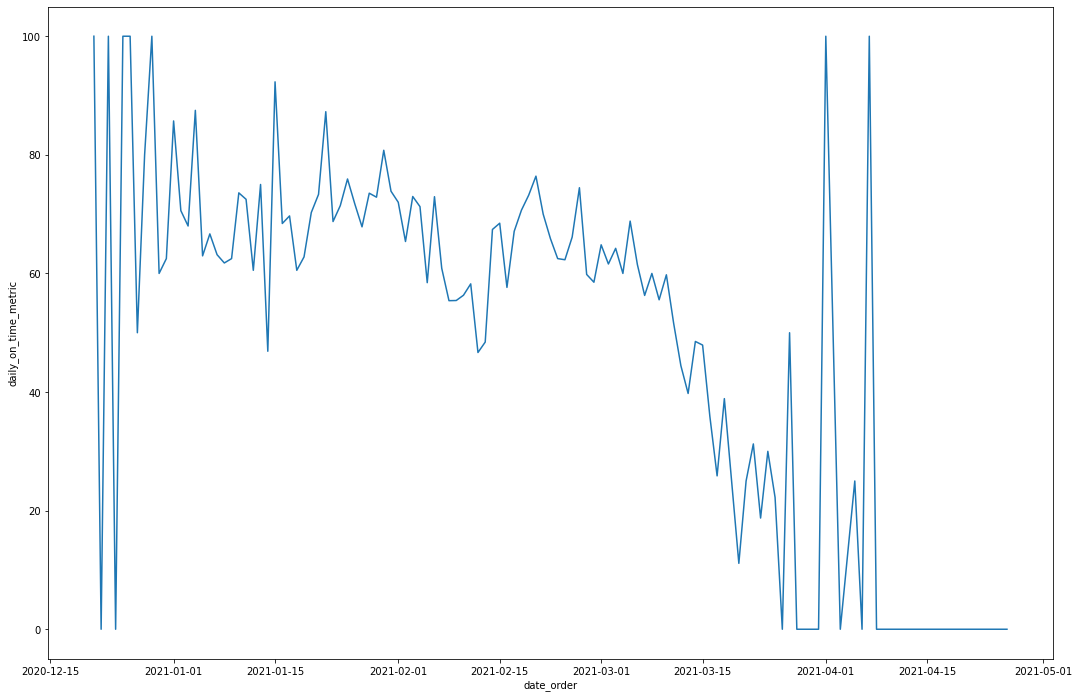

In [63]:
plt.figure(figsize = (18,12))
sns.lineplot(x = merged_orders.date_order, y = merged_orders.daily_on_time_metric)

In [64]:
#рассчитываем OnTime по перевозчикам

In [65]:
on_time_by_carrier = ((df_logistics.groupby('carrier_name').agg({'on_time_marker' : 'sum'}).rename(columns={'on_time_marker' : 'OnTime'}) / df_logistics.groupby('carrier_name').agg({'on_time_marker' : 'count'}).rename(columns={'on_time_marker' : 'OnTime'}))*100).reset_index().round(2) 
on_time_by_carrier

,carrier_name,OnTime
0,3PL 1,65.32
1,3PL 2,71.54
2,3PL 3,27.05
3,3PL 4,50.64
4,Самодоставка,60.68


<AxesSubplot:xlabel='carrier_name', ylabel='OnTime'>

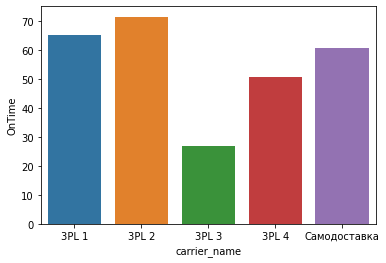

In [66]:
sns.barplot(x= on_time_by_carrier.carrier_name, y = on_time_by_carrier.OnTime)

In [67]:
#OnTime по типу доставки

In [68]:
on_time_by_delivery_type = ((df_logistics.groupby('delivery_type').agg({'on_time_marker' : 'sum'}).rename(columns={'on_time_marker' : 'OnTime'}) / df_logistics.groupby('delivery_type').agg({'on_time_marker' : 'count'}).rename(columns={'on_time_marker' : 'OnTime'}))*100).reset_index().round(2) 
on_time_by_delivery_type

,delivery_type,OnTime
0,Курьер,55.66
1,Самовывоз,69.98


<AxesSubplot:xlabel='delivery_type', ylabel='OnTime'>

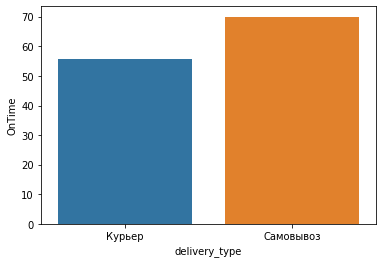

In [69]:
sns.barplot(x= on_time_by_delivery_type.delivery_type, y = on_time_by_delivery_type.OnTime)

In [70]:
#OnTime по кластерам

In [71]:
on_time_by_warehouse_cluster = ((df_logistics.groupby('warehouse_cluster').agg({'on_time_marker' : 'sum'}).rename(columns={'on_time_marker' : 'OnTime'}) / df_logistics.groupby('warehouse_cluster').agg({'on_time_marker' : 'count'}).rename(columns={'on_time_marker' : 'OnTime'}))*100).reset_index().round(2) 
on_time_by_warehouse_cluster

,warehouse_cluster,OnTime
0,Кластер Екатеринбург,87.43
1,Кластер Казань,73.08
2,Кластер Калининград,59.55
3,Кластер Краснодар,65.33
4,Кластер Москва,45.48
5,Кластер Московская область,43.36
6,Кластер Новосибирск,77.97
7,Кластер Санкт-Петербург,62.91
8,Кластер Северо-Запад,56.91
9,Кластер Хабаровск,25.00


<AxesSubplot:xlabel='warehouse_cluster', ylabel='OnTime'>

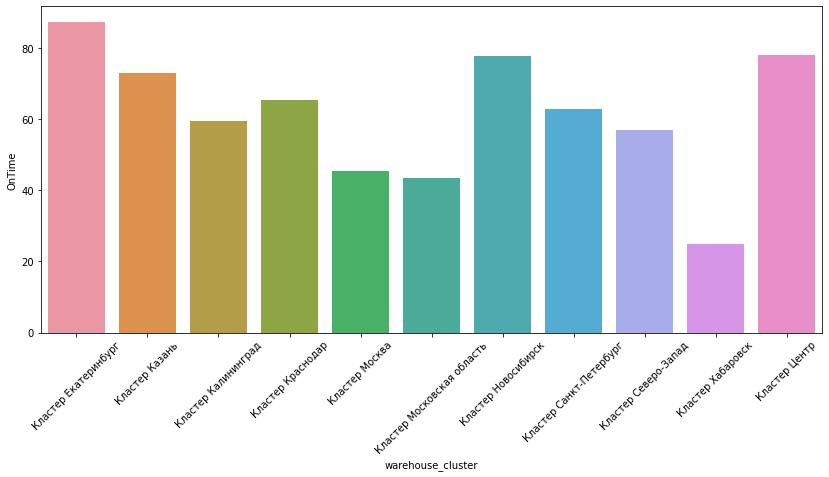

In [72]:
plt.figure(figsize = (14,6))
plt.xticks(rotation = 45)
sns.barplot(x= on_time_by_warehouse_cluster.warehouse_cluster, y = on_time_by_warehouse_cluster.OnTime)

In [73]:
#OnTime по таймслотам

In [74]:
on_time_by_timeslot_number = ((df_logistics.groupby('timeslot_number').agg({'on_time_marker' : 'sum'}).rename(columns={'on_time_marker' : 'OnTime'}) / df_logistics.groupby('timeslot_number').agg({'on_time_marker' : 'count'}).rename(columns={'on_time_marker' : 'OnTime'}))*100).reset_index().round(2) 
on_time_by_timeslot_number

,timeslot_number,OnTime
0,1,62.42


<AxesSubplot:xlabel='timeslot_number', ylabel='OnTime'>

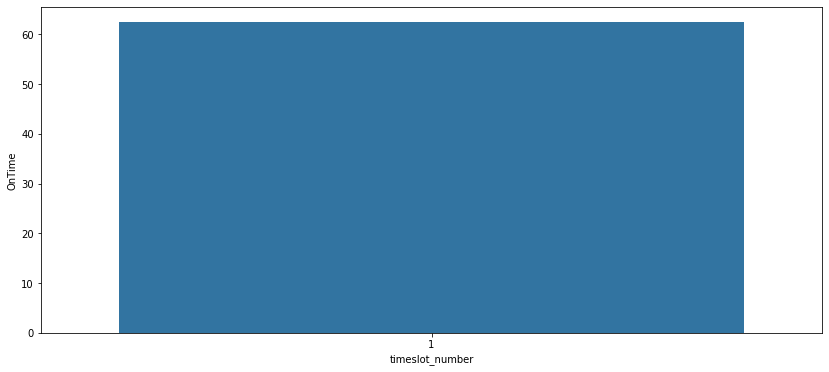

In [75]:
plt.figure(figsize = (14,6))
sns.barplot(x= on_time_by_timeslot_number.timeslot_number, y = on_time_by_timeslot_number.OnTime)

#### Задача 2. Посчитать PromisedClick2Delivery - метрика обещанного срока доставки (от даты заказа до первой плановой даты доставки), в сутках.

In [76]:
#проверяем, что ячеек без значений в date_order не осталось

In [77]:
df_logistics.isna().sum()

date_order              0
number_order            0
planned_data_order      0
timeslot_number         0
result_data_order     816
delivery_type           0
carrier_name            0
seller_ID               0
order_status            0
customer_cluster        0
warehouse_cluster       0
day_difference        816
on_time_marker          0
dtype: int64

In [78]:
# рассчитываем метрику PromisedClick2Delivery для каждой строки

In [79]:
df_logistics['PromisedClick2Delivery'] = (df_logistics.planned_data_order - df_logistics.date_order).dt.days

In [80]:
# PromisedClick2Delivery по дням

In [81]:
PromisedClick2Delivery_daily = (df_logistics.groupby('date_order').agg({'PromisedClick2Delivery' : 'mean'})).reset_index().sort_values('date_order').round(2)
PromisedClick2Delivery_daily

,date_order,PromisedClick2Delivery
0,2020-12-21,11.00
1,2020-12-22,11.00
2,2020-12-23,9.00
3,2020-12-24,8.00
4,2020-12-25,9.67
...,...,...
108,2021-04-20,10.00
109,2021-04-21,9.00
110,2021-04-22,4.00
111,2021-04-25,5.00


<AxesSubplot:xlabel='date_order', ylabel='PromisedClick2Delivery'>

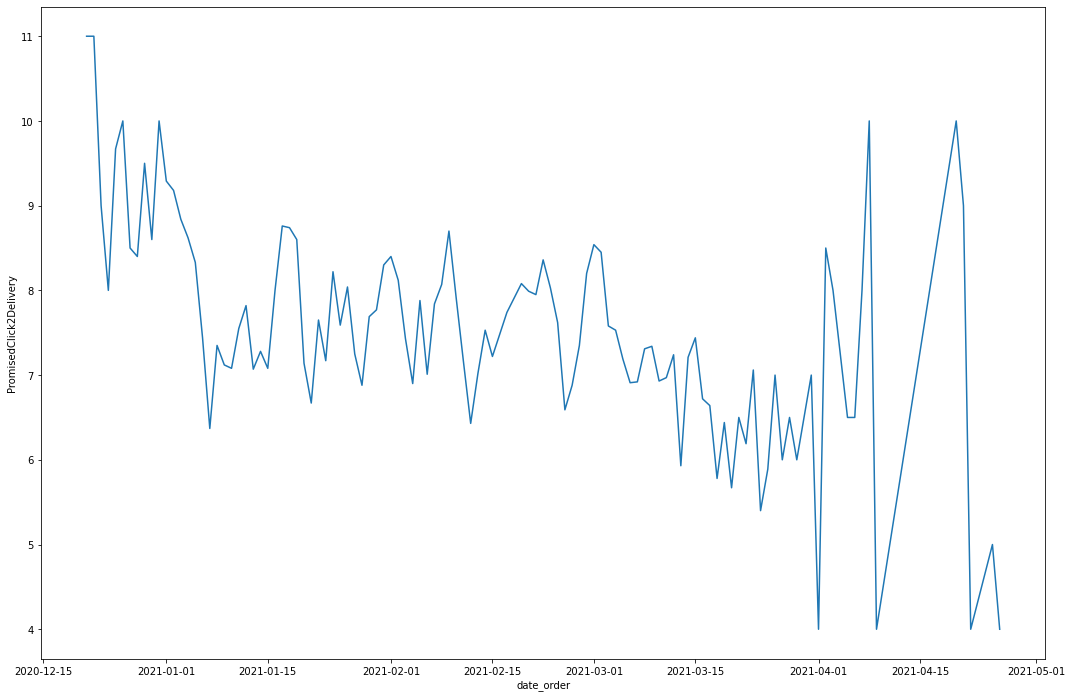

In [82]:
plt.figure(figsize = (18,12))
sns.lineplot(x = PromisedClick2Delivery_daily.date_order, y = PromisedClick2Delivery_daily.PromisedClick2Delivery)

In [83]:
# добавляем колонку с неделями, для возможности аггрегации по ним

In [84]:
df_logistics['week_order'] = df_logistics.date_order.dt.to_period('W')

In [85]:
df_logistics

,date_order,number_order,planned_data_order,timeslot_number,result_data_order,delivery_type,carrier_name,seller_ID,order_status,customer_cluster,warehouse_cluster,day_difference,on_time_marker,PromisedClick2Delivery,week_order
1918,2020-12-21,303621239,2021-01-01,1,2020-12-25,Самовывоз,3PL 2,68503,Доставлен,Кластер Казань,Кластер Москва,-7.0,1,11,2020-12-21/2020-12-27
4231,2020-12-22,305403721,2021-01-02,1,2021-01-05,Самовывоз,3PL 2,33120125,Доставлен,Кластер Северо-Запад,Кластер Краснодар,3.0,0,11,2020-12-21/2020-12-27
6358,2020-12-23,30150141149,2021-01-01,1,2020-12-29,Самовывоз,3PL 1,2619,Доставлен,Кластер Екатеринбург,Кластер Москва,-3.0,1,9,2020-12-21/2020-12-27
2718,2020-12-24,30665014144,2021-01-01,1,2021-01-04,Самовывоз,3PL 2,989330,Доставлен,Кластер Краснодар,Кластер Екатеринбург,3.0,0,8,2020-12-21/2020-12-27
1509,2020-12-24,307256994,2021-01-01,1,2021-01-04,Самовывоз,3PL 2,68503,Доставлен,Кластер Екатеринбург,Кластер Москва,3.0,0,8,2020-12-21/2020-12-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4874,2021-04-20,364457251,2021-04-30,1,NaT,Курьер,Самодоставка,33233692,На пути к клиенту,Кластер Казань,Кластер Московская область,NaN,0,10,2021-04-19/2021-04-25
6499,2021-04-21,3652014642,2021-04-30,1,NaT,Курьер,Самодоставка,33233692,Ожидает сборки,Кластер Москва,Кластер Московская область,NaN,0,9,2021-04-19/2021-04-25
4143,2021-04-22,3657451462,2021-04-26,1,NaT,Курьер,Самодоставка,120629,Отменен,Кластер Санкт-Петербург,Кластер Екатеринбург,NaN,0,4,2021-04-19/2021-04-25
5172,2021-04-25,3646995214,2021-04-30,1,NaT,Курьер,Самодоставка,33233692,На пути к клиенту,Кластер Московская область,Кластер Московская область,NaN,0,5,2021-04-19/2021-04-25


In [86]:
# PromisedClick2Delivery по неделям

In [87]:
PromisedClick2Delivery_weekly = (df_logistics.groupby('week_order').agg({'PromisedClick2Delivery' : 'mean'})).reset_index().sort_values('week_order').round(2)
PromisedClick2Delivery_weekly

,week_order,PromisedClick2Delivery
0,2020-12-21/2020-12-27,9.42
1,2020-12-28/2021-01-03,9.09
2,2021-01-04/2021-01-10,7.40
3,2021-01-11/2021-01-17,7.69
4,2021-01-18/2021-01-24,7.78
5,2021-01-25/2021-01-31,7.66
6,2021-02-01/2021-02-07,7.63
7,2021-02-08/2021-02-14,7.56
8,2021-02-15/2021-02-21,7.76
9,2021-02-22/2021-02-28,7.57


<AxesSubplot:ylabel='PromisedClick2Delivery'>

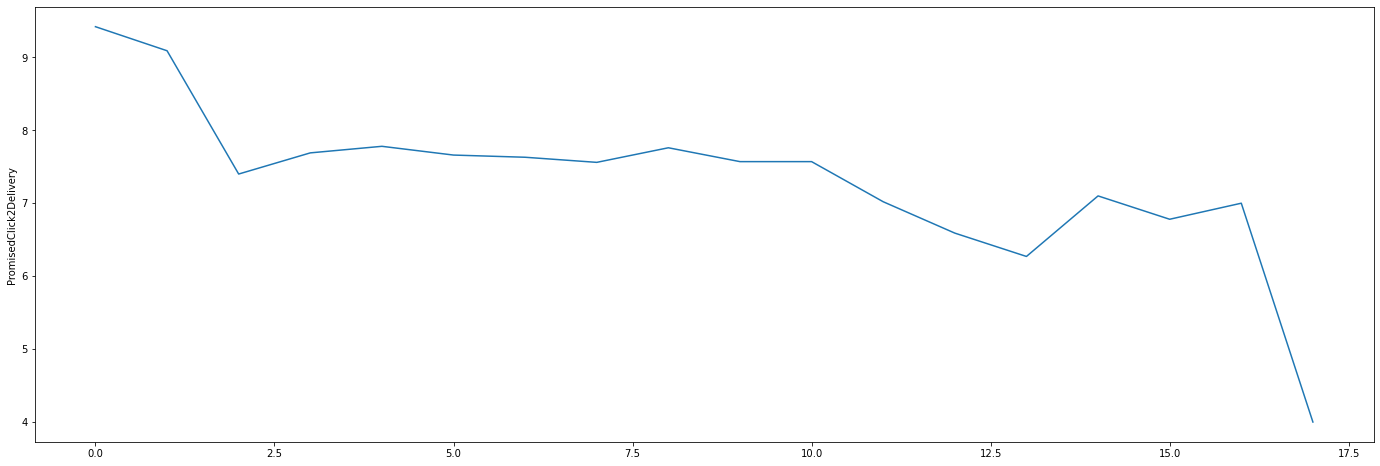

In [88]:
plt.figure(figsize = (24,8))
sns.lineplot(x = PromisedClick2Delivery_weekly.index, y = PromisedClick2Delivery_weekly.PromisedClick2Delivery)

In [89]:
# добавляем колонку с месяцем для аггрегации по месяцам

In [90]:
df_logistics['month_order'] = df_logistics.date_order.dt.to_period('M')

In [91]:
# PromisedClick2Delivery по месяцам

In [92]:
PromisedClick2Delivery_monthly = (df_logistics.groupby('month_order').agg({'PromisedClick2Delivery' : 'mean'})).reset_index().round(2)
PromisedClick2Delivery_monthly

,month_order,PromisedClick2Delivery
0,2020-12,9.28
1,2021-01,7.71
2,2021-02,7.63
3,2021-03,7.23
4,2021-04,6.90


<AxesSubplot:ylabel='PromisedClick2Delivery'>

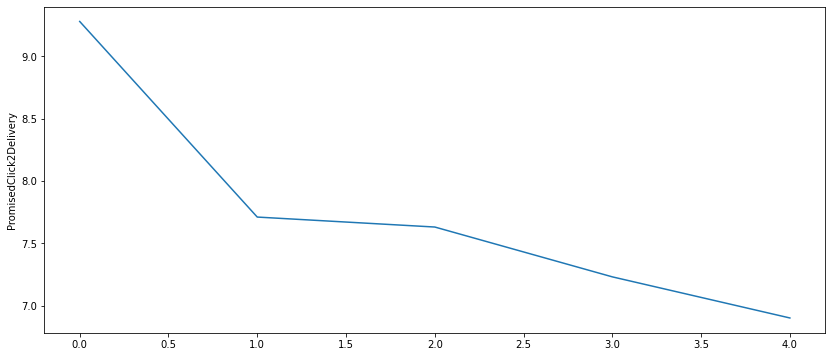

In [93]:
plt.figure(figsize = (14,6))
sns.lineplot(x = PromisedClick2Delivery_monthly.index, y = PromisedClick2Delivery_monthly.PromisedClick2Delivery)

In [94]:
# PromisedClick2Delivery по перевозчикам

In [95]:
PromisedClick2Delivery_carrier = (df_logistics.groupby('carrier_name').agg({'PromisedClick2Delivery' : 'mean'})).reset_index().round(2)
PromisedClick2Delivery_carrier

,carrier_name,PromisedClick2Delivery
0,3PL 1,7.52
1,3PL 2,7.56
2,3PL 3,7.47
3,3PL 4,7.49
4,Самодоставка,7.49


<AxesSubplot:xlabel='carrier_name', ylabel='PromisedClick2Delivery'>

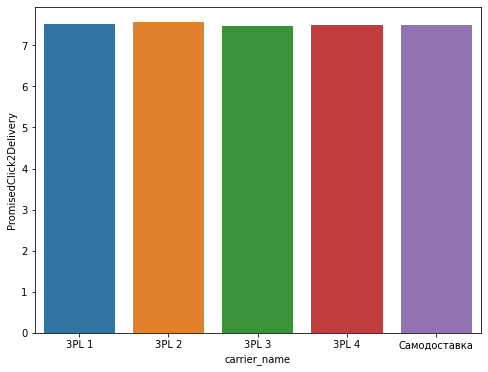

In [96]:
plt.figure(figsize = (8,6))
sns.barplot(x = PromisedClick2Delivery_carrier.carrier_name, y = PromisedClick2Delivery_carrier.PromisedClick2Delivery)

In [97]:
# PromisedClick2Delivery по кластерам

In [98]:
PromisedClick2Delivery_warehouse_cluster = (df_logistics.groupby('warehouse_cluster').agg({'PromisedClick2Delivery' : 'mean'})).reset_index().round(2)
PromisedClick2Delivery_warehouse_cluster

,warehouse_cluster,PromisedClick2Delivery
0,Кластер Екатеринбург,7.48
1,Кластер Казань,7.52
2,Кластер Калининград,7.58
3,Кластер Краснодар,7.45
4,Кластер Москва,7.51
5,Кластер Московская область,7.50
6,Кластер Новосибирск,7.73
7,Кластер Санкт-Петербург,7.57
8,Кластер Северо-Запад,7.45
9,Кластер Хабаровск,7.25


#### Задача 3. Посчитать Click2Delivery - метрика фактического срока доставки (от даты заказа до момента вручения), в сутках

In [99]:
# рассчитываем метрику Click2Delivery для каждой строки

In [100]:
df_logistics['Click2Delivery'] = (df_logistics.result_data_order - df_logistics.date_order).dt.days

In [101]:
#Click2Delivery для каждого дня. Рассчитывается как медианное значение.

In [102]:
Click2Delivery_daily = (df_logistics.groupby('date_order').agg({'Click2Delivery' : 'mean'})).reset_index().sort_values('date_order').round(2)
Click2Delivery_daily

,date_order,Click2Delivery
0,2020-12-21,4.00
1,2020-12-22,14.00
2,2020-12-23,6.00
3,2020-12-24,11.00
4,2020-12-25,5.67
...,...,...
108,2021-04-20,NaN
109,2021-04-21,NaN
110,2021-04-22,NaN
111,2021-04-25,NaN


In [103]:
# для сравнения метрик PromisedClick2Delivery и Click2Delivery создаем соответствую таблицу через слияние.

In [104]:
compare_delivery_daily = Click2Delivery_daily.merge(PromisedClick2Delivery_daily, on = 'date_order', how = 'inner')
compare_delivery_daily

,date_order,Click2Delivery,PromisedClick2Delivery
0,2020-12-21,4.00,11.00
1,2020-12-22,14.00,11.00
2,2020-12-23,6.00,9.00
3,2020-12-24,11.00,8.00
4,2020-12-25,5.67,9.67
...,...,...,...
108,2021-04-20,NaN,10.00
109,2021-04-21,NaN,9.00
110,2021-04-22,NaN,4.00
111,2021-04-25,NaN,5.00


<AxesSubplot:xlabel='date_order', ylabel='Click2Delivery'>

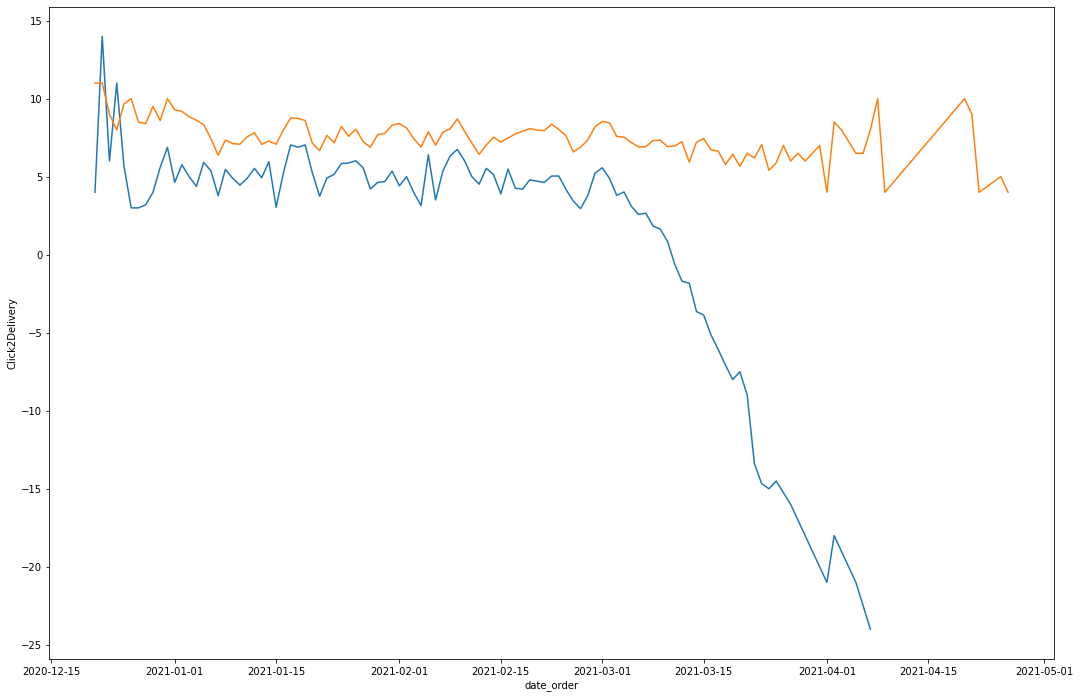

In [105]:
plt.figure(figsize = (18,12))
sns.lineplot(x = compare_delivery_daily.date_order, y = compare_delivery_daily.Click2Delivery)
sns.lineplot(x = compare_delivery_daily.date_order, y = compare_delivery_daily.PromisedClick2Delivery)

График выше показывает, что начиная с марта 2021 года данные по фактической доставке товаров были записаны неверно, так как фактическая доставка не может происходить раньше даты непосредсвенно заказа. Дата заказа скорее всего записана верно, так как для метрики PromisedClick2Delivery таких сильных отклонений не наблюдается.

Для определения кластеров, где заказы доставляются быстрее, чем мы обещаем клиентам, данные взяты только от начала записи до марта 2021, чтобы избежать некорректных выводов.

In [106]:
df_logistics_corrected = df_logistics.query("date_order >= '2020-12-21' and date_order < '2021-03-01' ")

In [107]:
df_logistics_corrected.head(5)

,date_order,number_order,planned_data_order,timeslot_number,result_data_order,delivery_type,carrier_name,seller_ID,order_status,customer_cluster,warehouse_cluster,day_difference,on_time_marker,PromisedClick2Delivery,week_order,month_order,Click2Delivery
1918,2020-12-21,303621239,2021-01-01,1,2020-12-25,Самовывоз,3PL 2,68503,Доставлен,Кластер Казань,Кластер Москва,-7.0,1,11,2020-12-21/2020-12-27,2020-12,4.0
4231,2020-12-22,305403721,2021-01-02,1,2021-01-05,Самовывоз,3PL 2,33120125,Доставлен,Кластер Северо-Запад,Кластер Краснодар,3.0,0,11,2020-12-21/2020-12-27,2020-12,14.0
6358,2020-12-23,30150141149,2021-01-01,1,2020-12-29,Самовывоз,3PL 1,2619,Доставлен,Кластер Екатеринбург,Кластер Москва,-3.0,1,9,2020-12-21/2020-12-27,2020-12,6.0
2718,2020-12-24,30665014144,2021-01-01,1,2021-01-04,Самовывоз,3PL 2,989330,Доставлен,Кластер Краснодар,Кластер Екатеринбург,3.0,0,8,2020-12-21/2020-12-27,2020-12,11.0
1509,2020-12-24,307256994,2021-01-01,1,2021-01-04,Самовывоз,3PL 2,68503,Доставлен,Кластер Екатеринбург,Кластер Москва,3.0,0,8,2020-12-21/2020-12-27,2020-12,11.0


In [108]:
# Click2Delivery для кластеров

In [109]:
Click2Delivery_warehouse_cluster = (df_logistics_corrected.groupby('warehouse_cluster').agg({'Click2Delivery' : 'mean'})).reset_index().round(2)
Click2Delivery_warehouse_cluster

,warehouse_cluster,Click2Delivery
0,Кластер Екатеринбург,0.38
1,Кластер Казань,4.30
2,Кластер Калининград,6.60
3,Кластер Краснодар,5.24
4,Кластер Москва,6.90
5,Кластер Московская область,6.67
6,Кластер Новосибирск,3.78
7,Кластер Санкт-Петербург,5.52
8,Кластер Северо-Запад,5.55
9,Кластер Хабаровск,8.14


In [110]:
PromisedClick2Delivery_warehouse_cluster_corr = (df_logistics_corrected.groupby('warehouse_cluster').agg({'PromisedClick2Delivery' : 'mean'})).reset_index().round(2)
PromisedClick2Delivery_warehouse_cluster_corr

,warehouse_cluster,PromisedClick2Delivery
0,Кластер Екатеринбург,7.65
1,Кластер Казань,7.62
2,Кластер Калининград,7.58
3,Кластер Краснодар,7.63
4,Кластер Москва,7.64
5,Кластер Московская область,7.69
6,Кластер Новосибирск,7.81
7,Кластер Санкт-Петербург,7.65
8,Кластер Северо-Запад,7.64
9,Кластер Хабаровск,7.14


In [111]:
# сравнение PromisedClick2Delivery и Click2Delivery для кластеров

In [112]:
compare_delivery_by_warehouse_cluster = Click2Delivery_warehouse_cluster.merge(PromisedClick2Delivery_warehouse_cluster_corr, on = 'warehouse_cluster', how = 'inner')
compare_delivery_by_warehouse_cluster

,warehouse_cluster,Click2Delivery,PromisedClick2Delivery
0,Кластер Екатеринбург,0.38,7.65
1,Кластер Казань,4.30,7.62
2,Кластер Калининград,6.60,7.58
3,Кластер Краснодар,5.24,7.63
4,Кластер Москва,6.90,7.64
5,Кластер Московская область,6.67,7.69
6,Кластер Новосибирск,3.78,7.81
7,Кластер Санкт-Петербург,5.52,7.65
8,Кластер Северо-Запад,5.55,7.64
9,Кластер Хабаровск,8.14,7.14


Во всех кластерах, кроме Хабаровска, в среднем товары доставляются быстрее обещанной даты доставки

#### Задача 4. Посчитать GMV Accepted - метрика совокупного объема продаж (считается по заказам, оформленным в указанный день), в рублях.

In [113]:
#в таблице returns_online, несмотря на корректный тип данных, формат даты представлен некорректно.
# Задаем функцию для исправленияю

In [114]:
df_returns

,number_order,product_ID,amount_return,return_date
0,3031410942,983588011,1,1970-01-01
1,31014374140,983586554,1,2021-07-01
2,3147145173,983589156,1,2021-11-01
3,3141464669,983589362,1,2021-11-01
4,3131450699,983589729,3,2021-12-01
...,...,...,...,...
491,35714135014,983587402,2,1970-01-01
492,35714135014,983584567,3,1970-01-01
493,35714135014,983587402,2,1970-01-01
494,361501547,983581947,1,1970-01-01


In [115]:
df_returns.dtypes

number_order              int64
product_ID                int64
amount_return              int8
return_date      datetime64[ns]
dtype: object

In [116]:
 def fix_dates_return(x):
        if str(x).startswith('202') :
            return str(x).split('-')[0] + '-' + str(x).split('-')[2] + '-' + str(x).split('-')[1]
        elif str(x).startswith('197'):
            return float('NaN')
        else:
            return x

In [117]:
df_returns.return_date = df_returns.return_date.apply(lambda x: str(x)[0:10])

In [118]:
df_returns.return_date = df_returns.return_date.apply(fix_dates_return)

In [119]:
df_returns

,number_order,product_ID,amount_return,return_date
0,3031410942,983588011,1,NaN
1,31014374140,983586554,1,2021-01-07
2,3147145173,983589156,1,2021-01-11
3,3141464669,983589362,1,2021-01-11
4,3131450699,983589729,3,2021-01-12
...,...,...,...,...
491,35714135014,983587402,2,NaN
492,35714135014,983584567,3,NaN
493,35714135014,983587402,2,NaN
494,361501547,983581947,1,NaN


In [120]:
# объединяем все три имеющиеся таблицы в одну.

In [121]:
merged_returns_product = df_product.merge(df_returns, on = ['number_order', 'product_ID'], how = 'left')

In [122]:
df_logistics_new = df_logistics.merge(merged_returns_product, on = 'number_order', how = 'left')

In [123]:
df_logistics_new.head(5)

,date_order,number_order,planned_data_order,timeslot_number,result_data_order,delivery_type,carrier_name,seller_ID,order_status,customer_cluster,...,on_time_marker,PromisedClick2Delivery,week_order,month_order,Click2Delivery,product_ID,product_price,amount,amount_return,return_date
0,2020-12-21,303621239,2021-01-01,1,2020-12-25,Самовывоз,3PL 2,68503,Доставлен,Кластер Казань,...,1,11,2020-12-21/2020-12-27,2020-12,4.0,983587080,7509.25,2,NaN,NaN
1,2020-12-21,303621239,2021-01-01,1,2020-12-25,Самовывоз,3PL 2,68503,Доставлен,Кластер Казань,...,1,11,2020-12-21/2020-12-27,2020-12,4.0,983585486,1099.65,3,NaN,NaN
2,2020-12-21,303621239,2021-01-01,1,2020-12-25,Самовывоз,3PL 2,68503,Доставлен,Кластер Казань,...,1,11,2020-12-21/2020-12-27,2020-12,4.0,983589573,5971.22,1,NaN,NaN
3,2020-12-22,305403721,2021-01-02,1,2021-01-05,Самовывоз,3PL 2,33120125,Доставлен,Кластер Северо-Запад,...,0,11,2020-12-21/2020-12-27,2020-12,14.0,983582201,6054.25,2,NaN,NaN
4,2020-12-23,30150141149,2021-01-01,1,2020-12-29,Самовывоз,3PL 1,2619,Доставлен,Кластер Екатеринбург,...,1,9,2020-12-21/2020-12-27,2020-12,6.0,983588424,4307.10,1,NaN,NaN


In [124]:
# добавляем колонку с суммой стоимости товара для каждой строки

In [125]:
df_logistics_new['order_total_price'] = df_logistics_new.product_price * df_logistics_new.amount

In [126]:
# GMV_Accepted по дням

In [127]:
GMV_Accepted_daily = df_logistics_new.groupby('date_order').agg({'order_total_price' : 'sum'}).rename(columns={'order_total_price' : 'GMV_Accepted' }).reset_index()
GMV_Accepted_daily

,date_order,GMV_Accepted
0,2020-12-21,24288.67
1,2020-12-22,12108.50
2,2020-12-23,4307.10
3,2020-12-24,32948.52
4,2020-12-25,77369.46
...,...,...
108,2021-04-20,6010.37
109,2021-04-21,1867.98
110,2021-04-22,15644.73
111,2021-04-25,5817.94


<AxesSubplot:xlabel='date_order', ylabel='GMV_Accepted'>

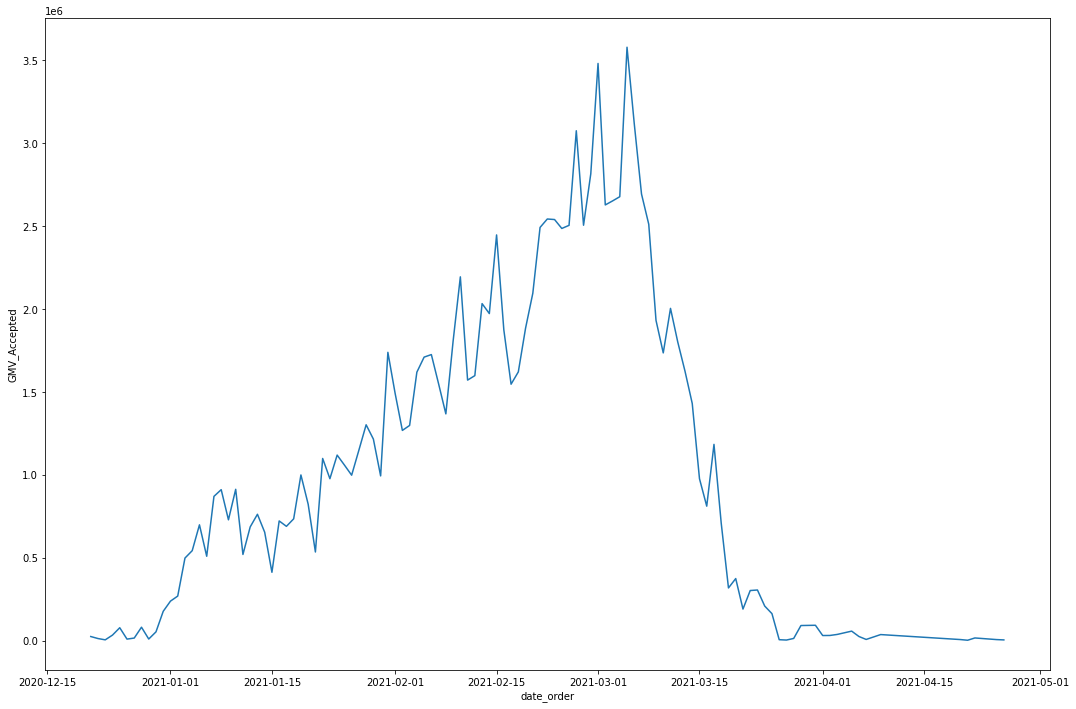

In [128]:
plt.figure(figsize = (18,12))
sns.lineplot(x = GMV_Accepted_daily.date_order, y = GMV_Accepted_daily.GMV_Accepted)

In [129]:
# GMV_Accepted по перевозчикам

In [130]:
GMV_Accepted_by_carrier = (df_logistics_new.groupby('carrier_name').agg({'order_total_price' : 'sum'})).rename(columns={'order_total_price' : 'GMV_Accepted'}).sort_values('GMV_Accepted').reset_index().round(2)
GMV_Accepted_by_carrier

,carrier_name,GMV_Accepted
0,3PL 4,5028255.44
1,3PL 3,7717946.35
2,3PL 1,33371414.48
3,3PL 2,35149114.70
4,Самодоставка,40120657.84


<AxesSubplot:xlabel='carrier_name', ylabel='GMV_Accepted'>

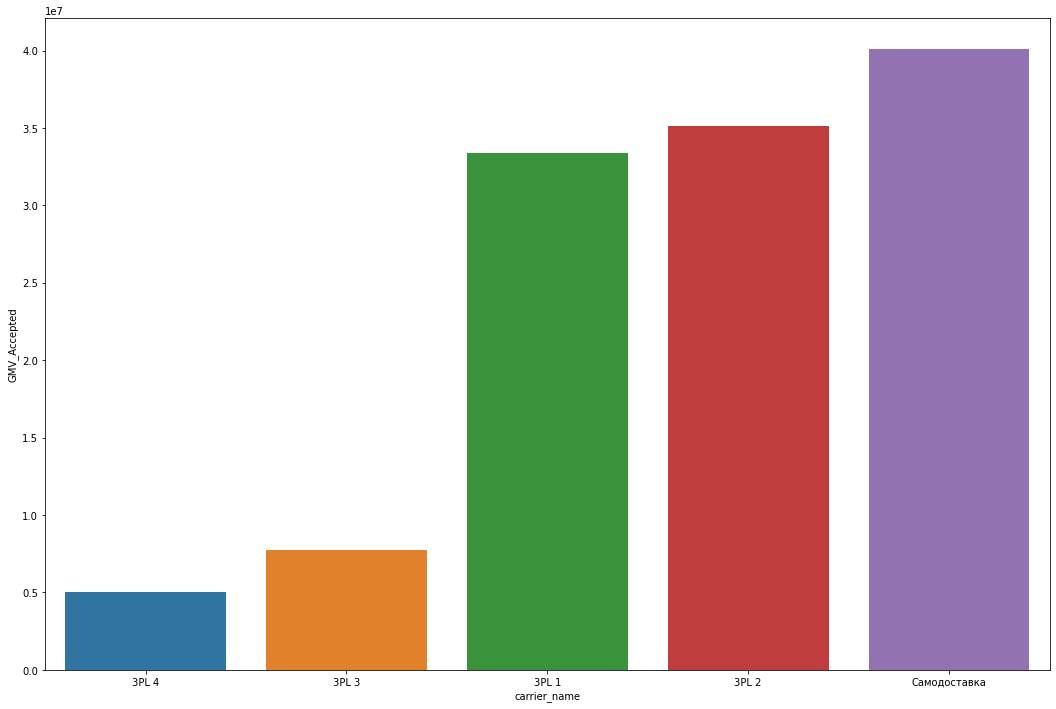

In [131]:
plt.figure(figsize = (18,12))
sns.barplot(x = GMV_Accepted_by_carrier.carrier_name, y = GMV_Accepted_by_carrier.GMV_Accepted)

In [132]:
#GMV_Accepted по типу доставки

In [133]:
GMV_Accepted_by_delivery_type = (df_logistics_new.groupby('delivery_type').agg({'order_total_price' : 'sum'})).rename(columns={'order_total_price' : 'GMV_Accepted'}).sort_values('GMV_Accepted').reset_index().round(2)
GMV_Accepted_by_delivery_type

,delivery_type,GMV_Accepted
0,Самовывоз,56788713.89
1,Курьер,64598674.92


In [134]:
#GMV_Accepted по кластерам

In [135]:
GMV_Accepted_by_warehouse_cluster = (df_logistics_new.groupby('warehouse_cluster').agg({'order_total_price' : 'sum'})).rename(columns={'order_total_price' : 'GMV_Accepted'}).reset_index().sort_values('GMV_Accepted').round(2)
GMV_Accepted_by_warehouse_cluster

,warehouse_cluster,GMV_Accepted
9,Кластер Хабаровск,133626.30
2,Кластер Калининград,2007903.56
8,Кластер Северо-Запад,3538355.13
10,Кластер Центр,4550606.64
6,Кластер Новосибирск,7039658.41
7,Кластер Санкт-Петербург,9476236.67
3,Кластер Краснодар,10442718.26
1,Кластер Казань,11301552.70
5,Кластер Московская область,18114930.16
0,Кластер Екатеринбург,22527581.87


<AxesSubplot:xlabel='warehouse_cluster', ylabel='GMV_Accepted'>

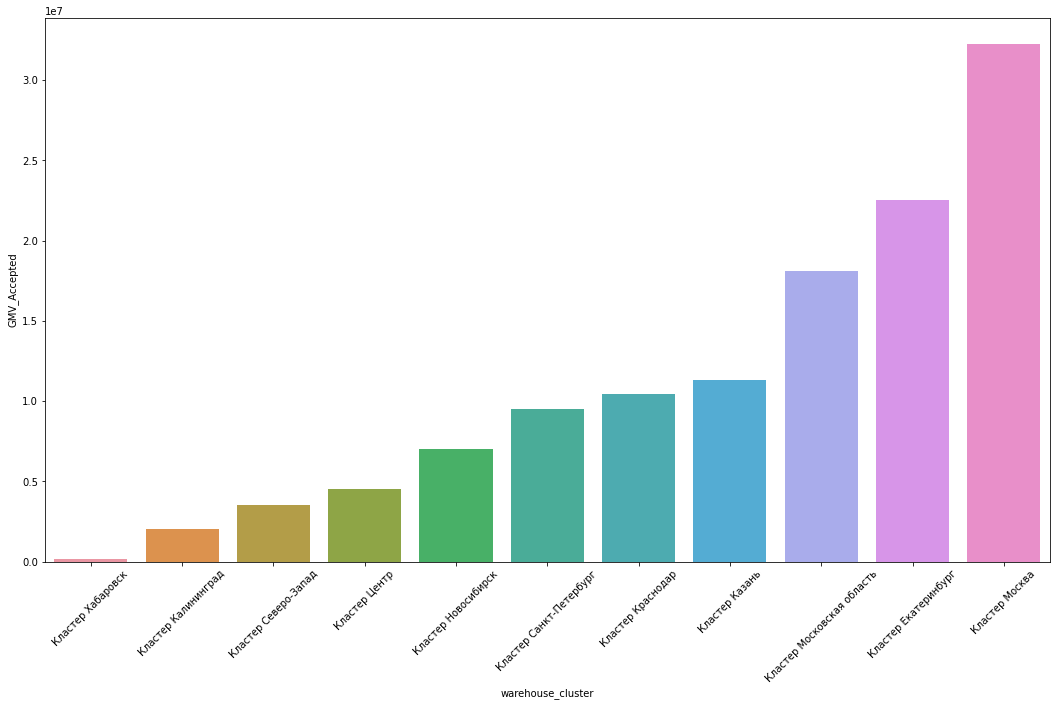

In [136]:
plt.figure(figsize = (18,10))
plt.xticks(rotation = 45)
sns.barplot(x = GMV_Accepted_by_warehouse_cluster.warehouse_cluster, y = GMV_Accepted_by_warehouse_cluster.GMV_Accepted)

#### Задача 5. Посчитать Return Rate - доля возвратов (отношение количества возвратов к заказам в этот день), в %. 

In [137]:
#Return_Rate по дням

In [138]:
Return_Rate_daily = (((df_logistics_new.groupby('date_order').agg({'amount_return' : 'count'}).rename(columns={'amount_return' : 'Return_Rate'}))/(df_logistics_new.groupby('date_order').agg({'date_order' : 'count'})).rename(columns={'date_order' : 'Return_Rate'}))*100).reset_index().sort_values('date_order').round(2)
Return_Rate_daily

,date_order,Return_Rate
0,2020-12-21,0.0
1,2020-12-22,0.0
2,2020-12-23,0.0
3,2020-12-24,0.0
4,2020-12-25,0.0
...,...,...
108,2021-04-20,0.0
109,2021-04-21,0.0
110,2021-04-22,0.0
111,2021-04-25,0.0


<AxesSubplot:xlabel='date_order', ylabel='Return_Rate'>

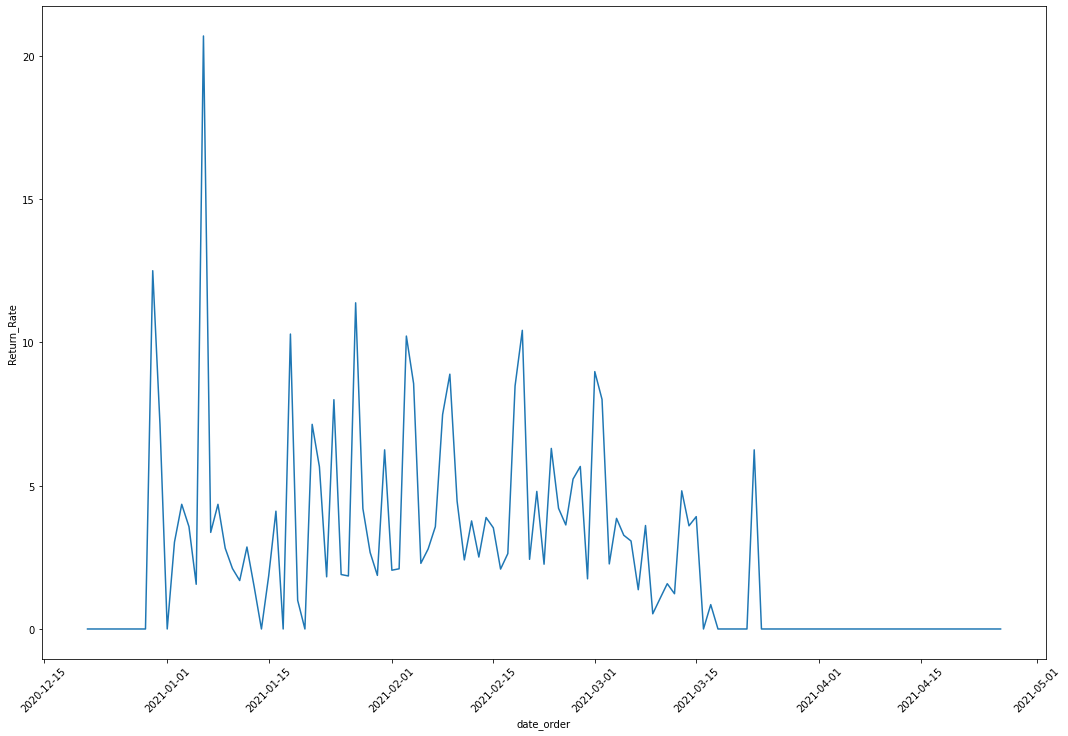

In [139]:
plt.figure(figsize = (18,12))
plt.xticks(rotation = 45)
sns.lineplot(x = Return_Rate_daily.date_order, y = Return_Rate_daily.Return_Rate)

In [140]:
#Return_Rate по перевозчику

In [141]:
Return_Rate_carrier = (((df_logistics_new.groupby('carrier_name').agg({'amount_return' : 'count'}).rename(columns={'amount_return' : 'Return_Rate'}))/(df_logistics_new.groupby('carrier_name').agg({'date_order' : 'count'})).rename(columns={'date_order' : 'Return_Rate'}))*100).reset_index().sort_values('Return_Rate').round(2)
Return_Rate_carrier

,carrier_name,Return_Rate
0,3PL 1,3.51
4,Самодоставка,3.92
2,3PL 3,4.21
1,3PL 2,4.35
3,3PL 4,5.63


<AxesSubplot:xlabel='carrier_name', ylabel='Return_Rate'>

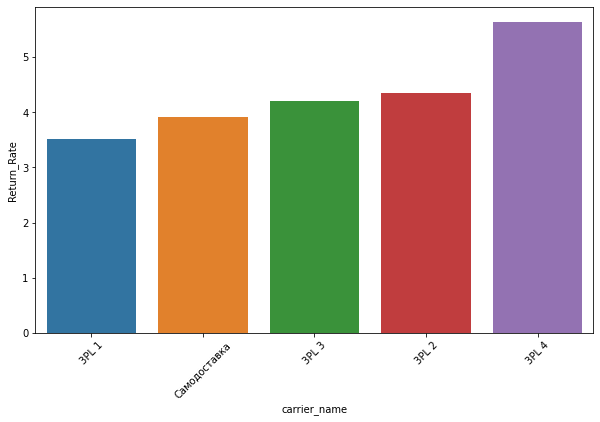

In [142]:
plt.figure(figsize = (10,6))
plt.xticks(rotation = 45)
sns.barplot(x = Return_Rate_carrier.carrier_name, y = Return_Rate_carrier.Return_Rate)

In [143]:
#Return_Rate по кластерам клиента

In [144]:
Return_Rate_customer_cluster = (((df_logistics_new.groupby('customer_cluster').agg({'amount_return' : 'count'}).rename(columns={'amount_return' : 'Return_Rate'}))/(df_logistics_new.groupby('customer_cluster').agg({'date_order' : 'count'})).rename(columns={'date_order' : 'Return_Rate'}))*100).reset_index().sort_values('Return_Rate').round(2)
Return_Rate_customer_cluster

,customer_cluster,Return_Rate
11,Кластер Якутия,0.00
8,Кластер Северо-Запад,1.41
3,Кластер Краснодар,3.31
0,Кластер Екатеринбург,3.36
6,Кластер Новосибирск,3.46
1,Кластер Казань,3.69
7,Кластер Санкт-Петербург,3.81
5,Кластер Московская область,4.13
4,Кластер Москва,4.57
10,Кластер Центр,5.76


<AxesSubplot:xlabel='customer_cluster', ylabel='Return_Rate'>

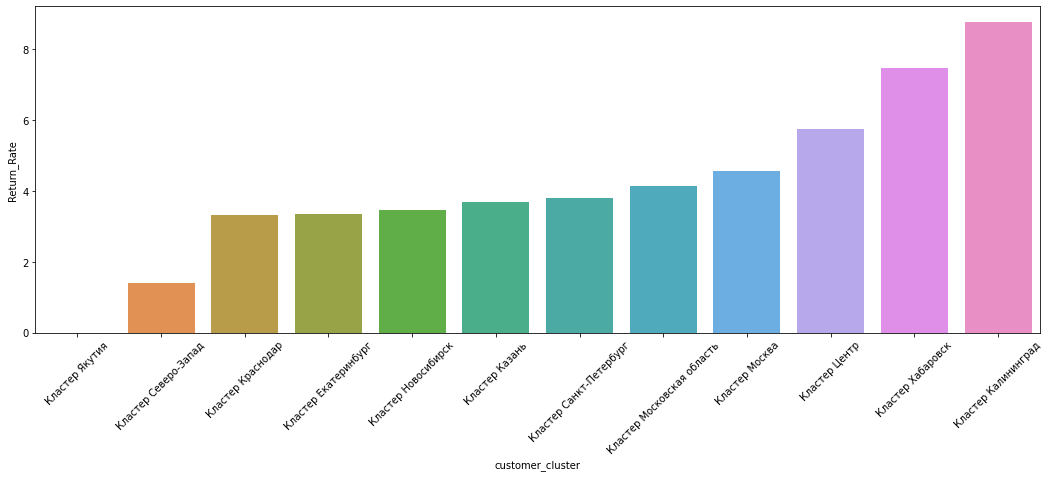

In [145]:
plt.figure(figsize = (18,6))
plt.xticks(rotation = 45)
sns.barplot(x = Return_Rate_customer_cluster.customer_cluster, y = Return_Rate_customer_cluster.Return_Rate)

In [146]:
#Return_Rate по кластерам склада

In [147]:
Return_Rate_warehouse_cluster = (((df_logistics_new.groupby('warehouse_cluster').agg({'amount_return' : 'count'}).rename(columns={'amount_return' : 'Return_Rate'}))/(df_logistics_new.groupby('warehouse_cluster').agg({'date_order' : 'count'})).rename(columns={'date_order' : 'Return_Rate'}))*100).reset_index().sort_values('Return_Rate').round(2)
Return_Rate_warehouse_cluster

,warehouse_cluster,Return_Rate
2,Кластер Калининград,2.56
7,Кластер Санкт-Петербург,2.68
10,Кластер Центр,3.00
6,Кластер Новосибирск,3.18
0,Кластер Екатеринбург,3.57
3,Кластер Краснодар,3.60
5,Кластер Московская область,4.15
4,Кластер Москва,4.36
1,Кластер Казань,5.13
9,Кластер Хабаровск,7.69


<AxesSubplot:xlabel='warehouse_cluster', ylabel='Return_Rate'>

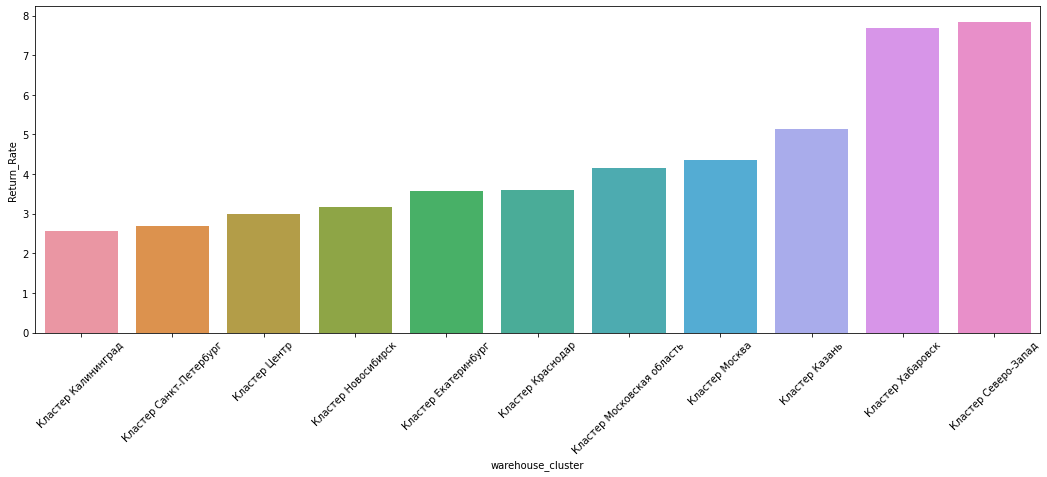

In [148]:
plt.figure(figsize = (18,6))
plt.xticks(rotation = 45)
sns.barplot(x = Return_Rate_warehouse_cluster.warehouse_cluster, y = Return_Rate_warehouse_cluster.Return_Rate)

#### Задача 6. Посчитать GMV D-R - метрика, отражающая совокупный объем доставленных заказов за вычетом возвратов, в рублях.

In [149]:
# добавляем в датафрейм колонку с суммой возврата в рублях по строкам

In [150]:
df_logistics_new['return_sum'] = df_logistics_new.product_price*df_logistics_new.amount_return

In [151]:
# сооздаем таблицу для расчета GMV_D_R по дням

In [152]:
GMV_D_R_daily = df_logistics_new.groupby('date_order')['order_total_price'].sum().reset_index().sort_values('date_order')
GMV_D_R_daily['cumulative_price'] = GMV_D_R_daily.order_total_price.cumsum().astype('float').round(1)

In [153]:
return_sum = df_logistics_new.groupby('date_order').agg({'return_sum' : 'sum'})

In [154]:
GMV_D_R_daily = GMV_D_R_daily.merge(return_sum, on = 'date_order', how = 'inner')

In [155]:
# GMV_D_R расчитана, кумулятивная сумма разницы стоимости товаров и стоимости возвращенных товаров.

In [156]:
GMV_D_R_daily['GMV_D_R'] = (GMV_D_R_daily.order_total_price - GMV_D_R_daily.return_sum).cumsum().astype('float').round(1)

In [157]:
GMV_D_R_daily

,date_order,order_total_price,cumulative_price,return_sum,GMV_D_R
0,2020-12-21,24288.67,24288.7,0.0,24288.7
1,2020-12-22,12108.50,36397.2,0.0,36397.2
2,2020-12-23,4307.10,40704.3,0.0,40704.3
3,2020-12-24,32948.52,73652.8,0.0,73652.8
4,2020-12-25,77369.46,151022.2,0.0,151022.2
...,...,...,...,...,...
108,2021-04-20,6010.37,121360179.4,0.0,117529469.4
109,2021-04-21,1867.98,121362047.4,0.0,117531337.4
110,2021-04-22,15644.73,121377692.1,0.0,117546982.1
111,2021-04-25,5817.94,121383510.0,0.0,117552800.0


In [158]:
# график кумулятивной суммы, и кумулятивной суммы с учетом возвратов (GMV_D_R)

<AxesSubplot:xlabel='date_order', ylabel='cumulative_price'>

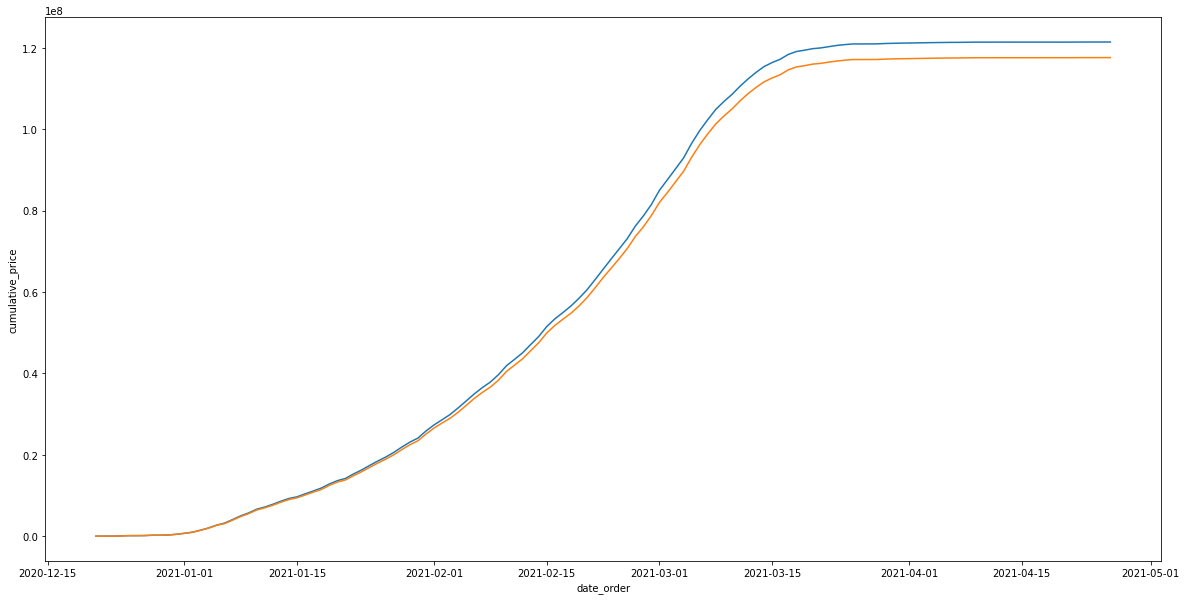

In [159]:
plt.figure(figsize = (20,10))
sns.lineplot(x = GMV_D_R_daily.date_order, y = GMV_D_R_daily.cumulative_price)
sns.lineplot(x = GMV_D_R_daily.date_order, y = GMV_D_R_daily.GMV_D_R)

In [160]:
#GMV_D_R по перевозчику

In [161]:
GMV_D_R_carrier = (((df_logistics_new.groupby('carrier_name').agg({'order_total_price' : 'sum'}).rename(columns={'order_total_price' : 'GMV_D_R'})) - (df_logistics_new.groupby('carrier_name').agg({'return_sum' : 'sum'})).rename(columns={'return_sum' : 'GMV_D_R'}))*100).reset_index().sort_values('GMV_D_R')
GMV_D_R_carrier

,carrier_name,GMV_D_R
3,3PL 4,4.756663e+08
2,3PL 3,7.480413e+08
0,3PL 1,3.252009e+09
1,3PL 2,3.384639e+09
4,Самодоставка,3.895313e+09


<AxesSubplot:xlabel='carrier_name', ylabel='GMV_D_R'>

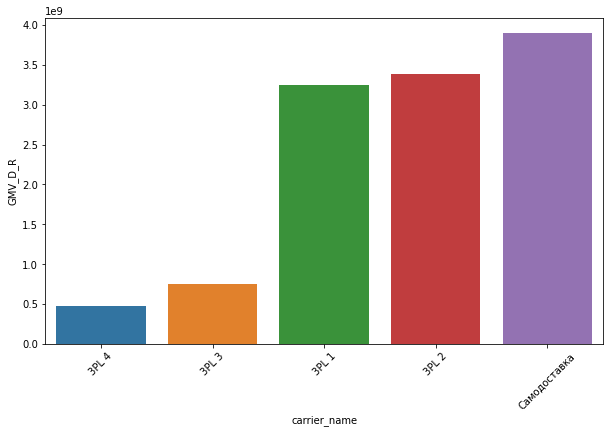

In [162]:
plt.figure(figsize = (10,6))
plt.xticks(rotation = 45)
sns.barplot(x = GMV_D_R_carrier.carrier_name, y = GMV_D_R_carrier.GMV_D_R)

In [163]:
#GMV_D_R по типу доставки

In [164]:
GMV_D_R_delivery_type = (((df_logistics_new.groupby('delivery_type').agg({'order_total_price' : 'sum'}).rename(columns={'order_total_price' : 'GMV_D_R'})) - (df_logistics_new.groupby('delivery_type').agg({'return_sum' : 'sum'})).rename(columns={'return_sum' : 'GMV_D_R'}))*100).reset_index().sort_values('GMV_D_R')
GMV_D_R_delivery_type

,delivery_type,GMV_D_R
1,Самовывоз,5.493675e+09
0,Курьер,6.261993e+09


In [165]:
# GMV_D_R по кластерам

In [166]:
GMV_D_R_warehouse_cluster = (((df_logistics_new.groupby('warehouse_cluster').agg({'order_total_price' : 'sum'}).rename(columns={'order_total_price' : 'GMV_D_R'})) - (df_logistics_new.groupby('warehouse_cluster').agg({'return_sum' : 'sum'})).rename(columns={'return_sum' : 'GMV_D_R'}))*100).reset_index().sort_values('GMV_D_R')
GMV_D_R_warehouse_cluster

,warehouse_cluster,GMV_D_R
9,Кластер Хабаровск,1.267557e+07
2,Кластер Калининград,1.970123e+08
8,Кластер Северо-Запад,3.293213e+08
10,Кластер Центр,4.493324e+08
6,Кластер Новосибирск,6.919539e+08
7,Кластер Санкт-Петербург,9.212408e+08
3,Кластер Краснодар,1.012702e+09
1,Кластер Казань,1.089575e+09
5,Кластер Московская область,1.754407e+09
0,Кластер Екатеринбург,2.181473e+09


<AxesSubplot:xlabel='warehouse_cluster', ylabel='GMV_D_R'>

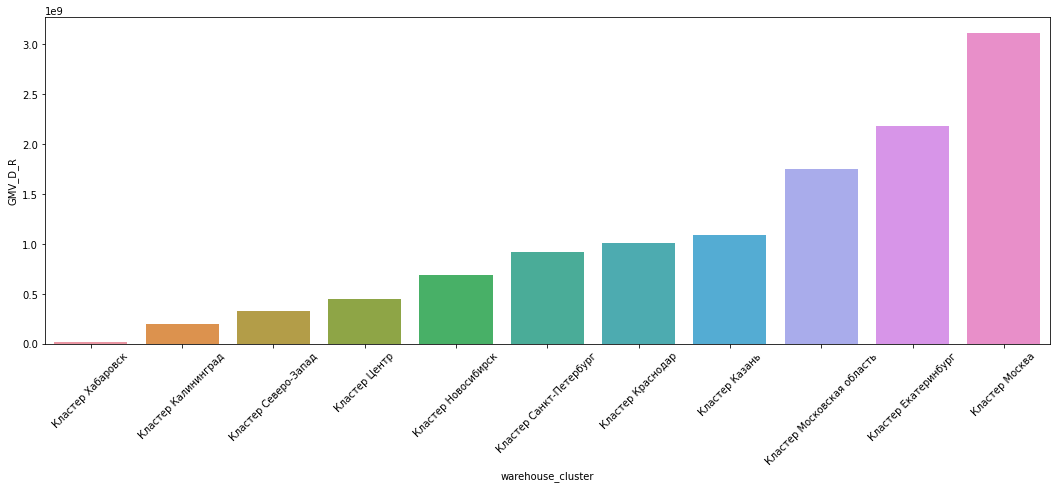

In [167]:
plt.figure(figsize = (18,6))
plt.xticks(rotation = 45)
sns.barplot(x = GMV_D_R_warehouse_cluster.warehouse_cluster, y = GMV_D_R_warehouse_cluster.GMV_D_R)